# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision

from torchvision.datasets import MNIST

## Acessando o dataset MNIST

O dataset MNIST é o dataset "hello world" do deep learning, criado por LeCun.
A versão do PyTorch é muito lenta para o download. Estamos usando aqui uma
versão menor com 20 mil amostras disponibilizados pelo próprio Colab.


In [ ]:
xy = np.array(pd.read_csv('sample_data/mnist_train_small.csv'))

In [ ]:
x_raw = xy[:,1:] # shape (19999,784) dtype int64
y_raw = xy[:,0 ] # shape (19999,)   dtype int64
x_raw.shape, y_raw.shape

((19999, 784), (19999,))

### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [ ]:
x_train = torch.FloatTensor(x_raw / 255.)
y_train = torch.LongTensor(y_raw)

if False:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.shape[0])

print("\nDimensões dos dados das imagens:   ", x_train.shape)
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", x_train.dtype)
print("Tipo das classes das imagens:      ", y_train.dtype)

Amostras de treinamento: 19999

Dimensões dos dados das imagens:    torch.Size([19999, 784])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         torch.float32
Tipo das classes das imagens:       torch.int64


### Visualizando os dados

In [ ]:
def to_pil(img):
    return torchvision.transforms.functional.to_pil_image(img, mode=None)

## make_grid é muito útil para mostrar mosaico de imagens no formato batch 4D:
(sample, channel, height, width)

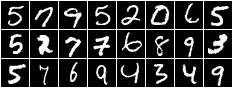

In [ ]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].reshape(-1,1,28,28), pad_value=1.0, padding=1)

to_pil(grid)

### Visualizando uma imagem com o matplotlib

class: tensor(5)


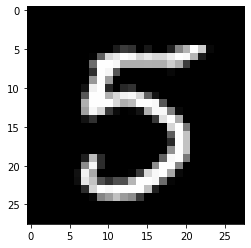

In [ ]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

## Modelo

In [ ]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [ ]:
model(x_train[:2])

tensor([[ 0.1150, -0.2250, -0.1190, -0.2539, -0.1949,  0.1037,  0.2203, -0.1310,
         -0.0629,  0.1655],
        [-0.0549, -0.0333,  0.1015, -0.1785, -0.3348,  0.0276, -0.0030,  0.0620,
          0.2528, -0.0534]], grad_fn=<AddmmBackward>)

## Treinamento

### Inicialização dos parâmetros

In [ ]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [ ]:
y_pred = model(x_train)
loss = criterion(y_pred, y_train)

In [ ]:
!pip install torchviz
import torchviz

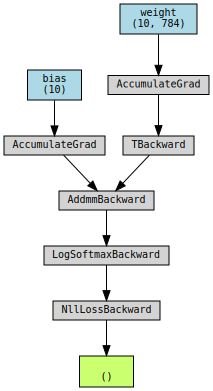

In [ ]:
p = torchviz.make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [ ]:
losses = []

for i in range(epochs):
    # Predict da rede
    logits = model( x_train)

    # calcula a perda
    loss = criterion(logits, y_train)

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

In [ ]:
print('Final loss:', loss.item())

Final loss: 0.38383591175079346


### Visualizando gráfico de perda durante o treinamento

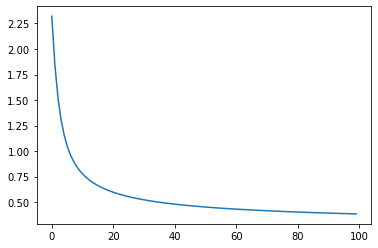

In [ ]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [ ]:
def predict(model, input_data):
    outputs = model(input_data)
    _, predicts = torch.max(outputs, 1)
    
    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.8979948997449873


### Matriz de confusão com dados de treinamento e teste

In [ ]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,1889,0,22,9,4,31,15,11,8,19
1,0,2165,25,16,15,21,6,26,57,16
2,7,12,1707,45,20,13,23,34,27,14
3,5,13,36,1744,2,81,1,7,56,33
4,4,4,46,0,1743,35,13,30,7,87
5,10,15,6,82,3,1436,28,2,47,10
6,22,5,43,18,20,32,1935,2,12,0
7,3,3,36,27,8,10,0,1933,16,60
8,20,24,54,48,13,72,15,9,1646,23


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


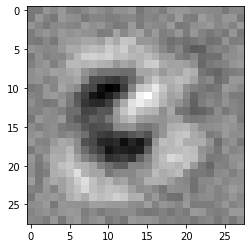

In [ ]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

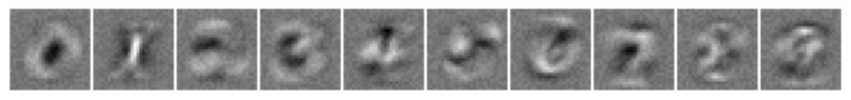

In [ ]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoSoftmaxArgmaxNMIST.png" width = "400">

# Atividades

## Exercícios

- 1) Na configuração da figura acima, mostre os valores de z0 até z9, os valores das probabilidades y_hat, após o softmax, quando a rede recebe como entrada a nona amostra que contém o manuscrito do dígito '4':

class: tensor(2)


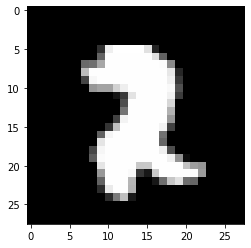

In [ ]:
image  = x_train[9]
target = y_train[9]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

- 2) Insira código no laço do treinamento para que no final de cada época, 
     seja impresso: o número da época e a perda e a acurácia

- 3) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
2. Qual é o shape da saída da rede?
3. Qual é o número total de parâmetros da rede, incluindo o bias?

# Aprendizados
